## Import the necessary libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys, os, glob, time, imageio
import numpy as np, pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from PIL import Image

import torch
import torchvision.utils as vutils
import torchvision.transforms as transforms

from keras import models, layers, optimizers
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

import tensorflow as tf


## Cheik the versions

In [ ]:
# Python version
print('Python version: {}'.format(sys.version))

# numpy
print('numpy version: {}'.format(np.__version__))

# pandas
print('pandas version: {}'.format(pd.__version__))

# matplotlib
import matplotlib; print('matplotlib version: {}'.format(matplotlib.__version__))

# torch
print('torch version: {}'.format(torch.__version__))

# scikit-learn
import sklearn; print('sklearn version: {}'.format(sklearn.__version__))

# tensorflow
print('tensorflow version: {}'.format(tf.__version__))

Python version: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
numpy version: 1.21.6
pandas version: 1.3.5
matplotlib version: 3.2.2
torch version: 1.12.1+cu113
sklearn version: 1.0.2
tensorflow version: 2.8.2


## Paths and lengths

In [ ]:
# Root directory for dataset
path_root = '/content/drive/MyDrive/COVID 19 DATASET/COVID-19/COVID-19/'
path_train= '/content/drive/MyDrive/COVID 19 DATASET/COVID-19/COVID-19/train/'
path_test = '/content/drive/MyDrive/COVID 19 DATASET/COVID-19/COVID-19/test/'
path_val  = '/content/drive/MyDrive/COVID 19 DATASET/COVID-19/COVID-1/val/'

# Root paths for X-Ray images
XRay_normal     = glob.glob(path_root+'*/NonCOVID/*.png', recursive=True)
#XRay_pneumonial = glob.glob(path_root+'*/PNEUMONIA/*.png', recursive=True)
XRay_covid      = glob.glob(path_root+'*/COVID/*.png', recursive=True)

# Root paths for X-Ray training images
train_normal    = glob.glob(path_train+'NonCOVID/*.png', recursive=True)
#train_pneumonial= glob.glob(path_train+'PNEUMONIA/*.jpeg', recursive=True)
train_covid    = glob.glob(path_train+'COVID/*.png', recursive=True)

# X-Ray testing images
test_normal     = os.listdir(path_test+'NonCOVID/')
#test_pneumonial = os.listdir(path_test+'PNEUMONIA/')
test_covid = os.listdir(path_test+'COVID/')

print('The "Chest X-Ray Images" dataset contains {:04d} NonCOVID and {:04d} COVID images ({:03d} in total)'\
      .format(len(XRay_normal),
              len(XRay_covid),
              len(glob.glob(path_root+'*/*/*.png')),))
print('   - {:04d} NORMAL and {:04d}  COVID ==> {:04d} images in the training sample'\
      .format(len(train_normal),
              len(train_covid),
              len(glob.glob(path_train+'*/*.png'))))
print('   - {:04d} NORMAL and {:04d}   COVID ==> {:04d} images in the testing sample'\
      .format(len(test_normal),
              len(test_covid),
              len(glob.glob(path_test+'*/*.png'))))
print('   - {:04d} NORMAL  {:04d} and COVID ==> {:04d} images in the validation sample'\
      .format(len(glob.glob(path_val+'NonCOVID/*.png')),
              len(glob.glob(path_val+'COVID/*.png')),
              len(glob.glob(path_val+'*/*.png'))))

The "Chest X-Ray Images" dataset contains 0195 NonCOVID and 0334 COVID images (529 in total)
   - 0115 NORMAL and 0191  COVID ==> 0306 images in the training sample
   - 0105 NORMAL and 0094   COVID ==> 0146 images in the testing sample
   - 0000 NORMAL  0000 and COVID ==> 0000 images in the validation sample


## Compute the time

In [ ]:
# Time
def _time(start, end):
    # if in seconds
    if (end-start)<60:
        wall_time = f'{round((end-start),2)}sec'
    # if in minute(s)
    elif (end-start)>=3600:
        wall_time = f'{int((end-start)/3600)}h {int(((end-start)%3600)/60)}min {round((end-start)%60,2)}sec'
    # if in houre(s)
    else:
        wall_time = f'{int((end-start)/60)}min {round((end-start)%60,2)}sec'
    return wall_time

## Take a quick look at of the images

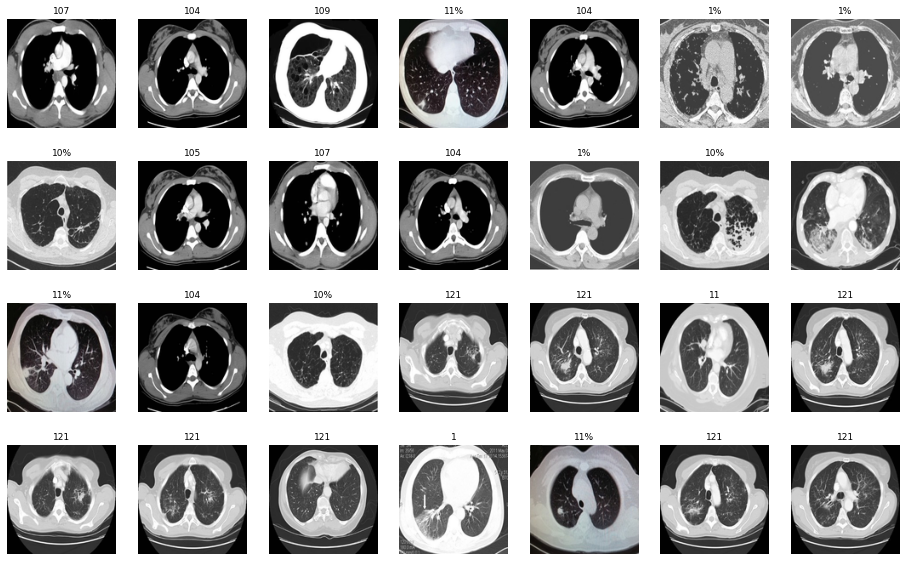

In [ ]:
nrows, ncols = 4, 7
plt.figure(figsize=(16,10))
for idx, name in enumerate(test_normal[:nrows*ncols]):
    plt.subplot(nrows, ncols, idx+1)
    img = Image.open(path_test+'NonCOVID/'+name) # or use plt.imread(path_test+'NORMAL/'+name)
    img = img.resize(size=(128, 128), resample=Image.ANTIALIAS, box=None)
    plt.imshow(img)
    plt.title(name[:-5], fontsize=9)
    plt.axis('off')

## Get data

In [ ]:
def get_data(data_path, dim=(128, 128), rand_shuffle=True):
    start = time.time()
    imgs_data = []
    sample_size = len(data_path)
    for idx, im_path in enumerate(data_path):
        if idx%(sample_size//10)==0:
            print('Processing index {:05d} of {:05d} ==> {:03d}%'\
                  .format(idx, sample_size, round(100*idx/sample_size)))
        img = img_to_array(load_img(im_path, target_size = dim))
        imgs_data.append(img)

    # to float
    imgs_data = np.array(imgs_data).astype('float32')
    # scale to [0,1] (note the . after 255 - float)
    imgs_data = imgs_data/255. #for formalizing to [-1,1] ==> (imgs_data - 127.5)/127.5

    # shuffle the data
    if rand_shuffle:
        idx = np.arange(imgs_data.shape[0])
        np.random.shuffle(idx)
        imgs_data = imgs_data[idx,:,:,:]

    print(f"Hey! the calculations are done in {_time(start, time.time())}")
    return imgs_data


In [ ]:
print('Starting for NORMAL X-Ray images ...')
X_normal = get_data(XRay_normal)
print()
#print('Starting for PNEUMONIA X-Ray images ...')
#X_pneumonial = get_data(XRay_pneumonial)
print()
print('Starting for COVID X-Ray images ...')
X_covid = get_data(XRay_covid)

Starting for NORMAL X-Ray images ...
Processing index 00000 of 00195 ==> 000%
Processing index 00019 of 00195 ==> 010%
Processing index 00038 of 00195 ==> 019%
Processing index 00057 of 00195 ==> 029%
Processing index 00076 of 00195 ==> 039%
Processing index 00095 of 00195 ==> 049%
Processing index 00114 of 00195 ==> 058%
Processing index 00133 of 00195 ==> 068%
Processing index 00152 of 00195 ==> 078%
Processing index 00171 of 00195 ==> 088%
Processing index 00190 of 00195 ==> 097%
Hey! the calculations are done in 43.28sec


Starting for COVID X-Ray images ...
Processing index 00000 of 00334 ==> 000%
Processing index 00033 of 00334 ==> 010%
Processing index 00066 of 00334 ==> 020%
Processing index 00099 of 00334 ==> 030%
Processing index 00132 of 00334 ==> 040%
Processing index 00165 of 00334 ==> 049%
Processing index 00198 of 00334 ==> 059%
Processing index 00231 of 00334 ==> 069%
Processing index 00264 of 00334 ==> 079%
Processing index 00297 of 00334 ==> 089%
Processing index 0033

In [ ]:
def define_grid(data_images, nrows=2, ncols=2, plot_grid=True):
    # save the started time
    start = time.time()
    # Number of GPUs available. Use 0 for CPU mode.
    ngpu = 1
    # Decide which device we want to run on
    device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
    # Rearange the shaphe of the data
    data_transp = [np.transpose(data_images[i,:,:]) for i in range(data_images[:nrows*ncols].shape[0])]
    # From to torch type for the grid
    data_transp = torch.Tensor(data_transp)
    print(f'The shape is reordered from {data_images.shape[1:]} to {data_transp.shape[1:]} in {_time(start, time.time())}')

    # Make the grid
    grid_images = np.transpose(
        vutils.make_grid(
            data_transp.to(device)[:nrows*ncols],
            nrow=nrows,
            padding=2,
            normalize=True,
            scale_each=True,
            pad_value=1,
        ).cpu(), axes=(2,1,0))

    # Show the output grid
    if plot_grid:
        plt.figure(figsize=(12,12))
        plt.axis("off")
        plt.title(f'Grid of {nrows*ncols} real images', fontsize=27)
        plt.imshow(grid_images)

    return grid_images

grid_X_normal = define_grid(X_normal, plot_grid=False)
#grid_X_pneumonial = define_grid(X_pneumonial, plot_grid=False)
grid_X_covid = define_grid(X_covid, plot_grid=False)

The shape is reordered from (128, 128, 3) to torch.Size([3, 128, 128]) in 0.11sec


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  # This is added back by InteractiveShellApp.init_path()


The shape is reordered from (128, 128, 3) to torch.Size([3, 128, 128]) in 0.02sec


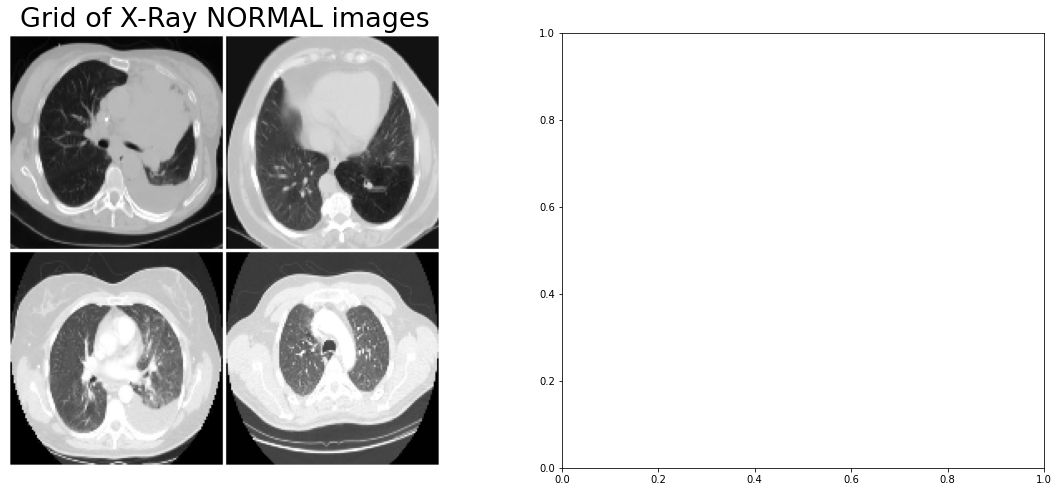

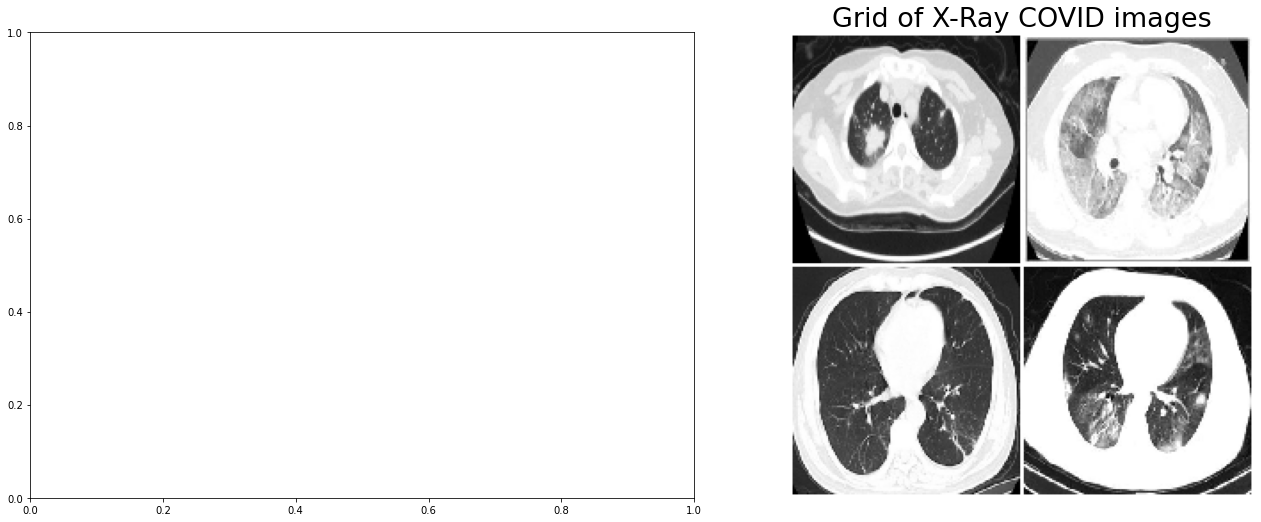

In [ ]:
fig, (ax1, ax2)= plt.subplots(nrows=1, ncols=2, figsize=(19, 8))

fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2, figsize=(19, 8))

ax1.imshow(grid_X_normal); ax1.axis('off')
ax1.set_title(label = 'Grid of X-Ray NORMAL images', fontsize = 27)

#ax2.imshow(grid_X_pneumonial); ax2.axis('off')
#ax2.set_title(label = 'Grid of X-Ray PNEUMONIA images', fontsize = 27)

ax3.imshow(grid_X_covid); ax3.axis('off')
ax3.set_title(label = 'Grid of X-Ray COVID images', fontsize = 27)

plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=[0, 0.03, 1, 0.95])

## Set the parameters  

In [ ]:
# Number of images to use (will be changed)
#n_images = 12_000

# Number of training epochs
n_epoch = 4000

# Batch size during training
batch_size = 128

# Size of z latent vector (i.e. size of generator input)
latent_dim = 100

# Spatial size of training images. All images will be resized to this size
cols, rows = 128, 128

# Number of channels in the training images. For RGB color images this is 3
channels = 3
dim = cols, rows # height, width
in_shape = (cols, rows, channels) # height, width, color

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# plot ncols images in row and nrows images in colomn
nrows, ncols = 3, 4


# Discriminator

In [ ]:
def define_discriminator(in_shape=(128,128,3)):
    model = models.Sequential()
    # normal
    model.add(layers.Conv2D(128, (5,5), padding='same', input_shape=in_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    # downsample to 64x64
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # downsample to 32x32
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # downsample to 16x16
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # downsample to 8x8
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # classifier
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation='sigmoid'))
    # compile model
    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

## Generator

In [ ]:
def define_generator(latent_dim):
    model = models.Sequential()
    # foundation for 8x8 feature maps
    n_nodes = 128*8*8
    model.add(layers.Dense(n_nodes, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((8, 8, 128)))
    # upsample to 16x16
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample to 64x64
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample to 128x128
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # output layer 128x128x3
    model.add(layers.Conv2D(3, (5,5), activation='tanh', padding='same'))
    return model

#input of G
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim*n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

## Define GAN model

In [ ]:
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = models.Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# retrive real samples
def get_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # set 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

# create and save a plot of generated images
def show_generated(generated, epoch, nrows=4, ncols=5):
    #[-1,1] -> [0,1]
    #generated = (generated+1)/2
    #generated = (generated[:ncols*nrows]*127.5)+127.5
    #generated = generated*255
    plt.figure(figsize=(10,10))
    for idx in range(nrows*ncols):
        plt.subplot(nrows, ncols, idx+1)
        plt.imshow(generated[idx])
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch+1))
    plt.show()

# evaluate the discriminator and plot generated images
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = get_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('> Accuracy at epoch %d [real: %.0f%%, fake: %.0f%%]'%(epoch+1, acc_real*100, acc_fake*100))
    # show plot
    show_generated(x_fake, epoch)

def plot_loss(loss):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training", fontsize=20)
    plt.plot(loss[0], label="D_real")
    plt.plot(loss[1], label="D_fake")
    plt.plot(loss[2], label="G")
    plt.xlabel("Iteration", fontsize=20); plt.ylabel("Loss", fontsize=20)
    plt.legend(); plt.show()

# Train the models

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim=100, n_epochs=100, n_batch=128):

    start = time.time()
    bat_per_epo = int(dataset.shape[0]/n_batch)
    half_batch = int(n_batch/2)
    loss1, loss2, loss3 = [], [], []
    fake_liste = []
    #global d_loss1, _

    # manually enumerate epochs
    print('Training Start...')
    for i in range(n_epochs):
        start1 = time.time()
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = get_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            loss1.append(d_loss1); loss2.append(d_loss2); loss3.append(g_loss)

        print('Epoch: {:03d}/{:03d}, Loss: [D_real = {:2.3f}, D_fake = {:2.3f}, G = {:2.3f}], time: {:s}'\
              .format(i+1,n_epochs,d_loss1,d_loss2,g_loss, _time(start1,time.time())))
        # evaluate the model performance
        if (i+1)%(n_epochs//10) == 0:
            # Save and show generated images
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

    print('Total time for training {} epochs is {} sec'.format(n_epochs, _time(start, time.time())))

    # Show loss curves
    loss = (loss1, loss2, loss3)
    plot_loss(loss)

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
discriminator = define_discriminator()
generator = define_generator(latent_dim)

# create the gan
gan = define_gan(generator, discriminator)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)




Training Start...
Epoch: 001/4000, Loss: [D_real = 0.482, D_fake = 0.698, G = 0.690], time: 17.07sec
Epoch: 002/4000, Loss: [D_real = 0.002, D_fake = 0.746, G = 0.667], time: 1.71sec
Epoch: 003/4000, Loss: [D_real = 0.007, D_fake = 0.773, G = 0.673], time: 1.72sec
Epoch: 004/4000, Loss: [D_real = 0.051, D_fake = 0.948, G = 0.657], time: 1.72sec
Epoch: 005/4000, Loss: [D_real = 0.253, D_fake = 1.017, G = 0.643], time: 1.73sec
Epoch: 006/4000, Loss: [D_real = 0.422, D_fake = 0.739, G = 0.848], time: 1.73sec
Epoch: 007/4000, Loss: [D_real = 0.195, D_fake = 0.646, G = 1.007], time: 1.71sec
Epoch: 008/4000, Loss: [D_real = 0.120, D_fake = 0.713, G = 0.684], time: 1.71sec
Epoch: 009/4000, Loss: [D_real = 0.013, D_fake = 0.710, G = 0.690], time: 1.71sec
Epoch: 010/4000, Loss: [D_real = 0.017, D_fake = 0.694, G = 0.713], time: 1.72sec
Epoch: 011/4000, Loss: [D_real = 0.016, D_fake = 0.658, G = 0.806], time: 1.74sec
Epoch: 012/4000, Loss: [D_real = 0.015, D_fake = 0.516, G = 1.604], time: 1.7

> Accuracy at epoch 400 [real: 88%, fake: 100%]


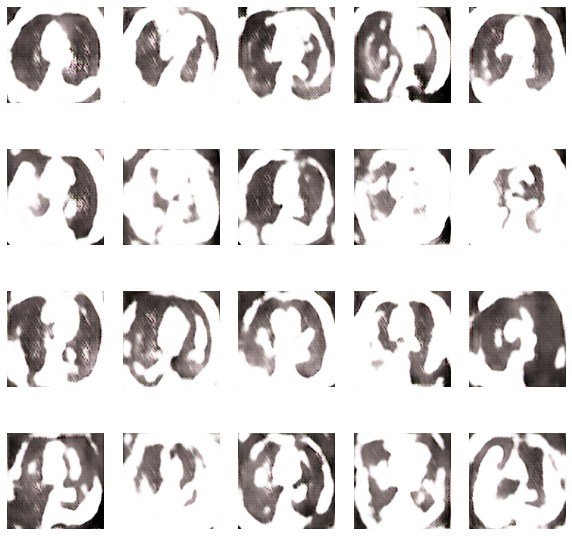

Epoch: 401/4000, Loss: [D_real = 0.115, D_fake = 0.113, G = 3.720], time: 1.72sec
Epoch: 402/4000, Loss: [D_real = 0.186, D_fake = 0.143, G = 4.110], time: 1.71sec
Epoch: 403/4000, Loss: [D_real = 0.215, D_fake = 0.075, G = 3.531], time: 1.73sec
Epoch: 404/4000, Loss: [D_real = 0.836, D_fake = 0.179, G = 2.488], time: 1.72sec
Epoch: 405/4000, Loss: [D_real = 0.406, D_fake = 0.545, G = 3.310], time: 1.72sec
Epoch: 406/4000, Loss: [D_real = 0.443, D_fake = 0.201, G = 2.708], time: 1.73sec
Epoch: 407/4000, Loss: [D_real = 0.147, D_fake = 0.158, G = 3.247], time: 1.73sec
Epoch: 408/4000, Loss: [D_real = 0.228, D_fake = 0.379, G = 4.486], time: 1.72sec
Epoch: 409/4000, Loss: [D_real = 0.166, D_fake = 0.272, G = 4.374], time: 1.72sec
Epoch: 410/4000, Loss: [D_real = 0.187, D_fake = 0.295, G = 4.721], time: 1.72sec
Epoch: 411/4000, Loss: [D_real = 0.107, D_fake = 0.284, G = 4.045], time: 1.72sec
Epoch: 412/4000, Loss: [D_real = 0.230, D_fake = 0.224, G = 3.072], time: 1.71sec
Epoch: 413/4000,

> Accuracy at epoch 800 [real: 98%, fake: 100%]


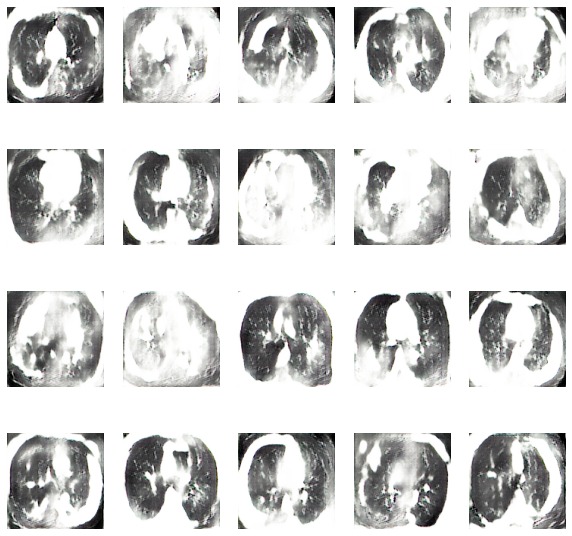

Epoch: 801/4000, Loss: [D_real = 0.046, D_fake = 0.092, G = 4.685], time: 1.73sec
Epoch: 802/4000, Loss: [D_real = 0.212, D_fake = 0.250, G = 4.730], time: 1.72sec
Epoch: 803/4000, Loss: [D_real = 0.099, D_fake = 0.119, G = 5.010], time: 1.72sec
Epoch: 804/4000, Loss: [D_real = 0.147, D_fake = 0.273, G = 5.376], time: 1.72sec
Epoch: 805/4000, Loss: [D_real = 0.273, D_fake = 0.096, G = 4.012], time: 1.71sec
Epoch: 806/4000, Loss: [D_real = 0.106, D_fake = 0.189, G = 5.683], time: 1.72sec
Epoch: 807/4000, Loss: [D_real = 0.082, D_fake = 0.073, G = 4.566], time: 1.72sec
Epoch: 808/4000, Loss: [D_real = 0.083, D_fake = 0.162, G = 6.265], time: 1.71sec
Epoch: 809/4000, Loss: [D_real = 0.298, D_fake = 0.126, G = 3.736], time: 1.72sec
Epoch: 810/4000, Loss: [D_real = 0.166, D_fake = 0.095, G = 4.937], time: 1.72sec
Epoch: 811/4000, Loss: [D_real = 0.035, D_fake = 0.128, G = 6.018], time: 1.72sec
Epoch: 812/4000, Loss: [D_real = 0.071, D_fake = 0.249, G = 7.056], time: 1.72sec
Epoch: 813/4000,

> Accuracy at epoch 1200 [real: 100%, fake: 100%]


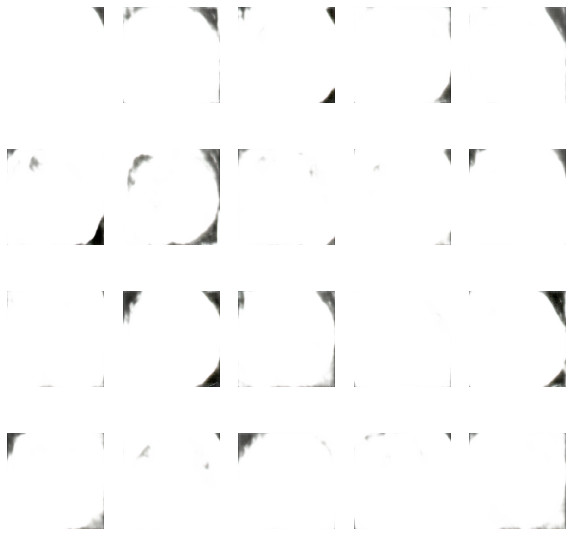

Epoch: 1201/4000, Loss: [D_real = 0.002, D_fake = 0.003, G = 10.436], time: 1.73sec
Epoch: 1202/4000, Loss: [D_real = 0.001, D_fake = 0.006, G = 9.743], time: 1.73sec
Epoch: 1203/4000, Loss: [D_real = 0.046, D_fake = 0.020, G = 10.451], time: 1.73sec
Epoch: 1204/4000, Loss: [D_real = 0.019, D_fake = 0.007, G = 11.344], time: 1.72sec
Epoch: 1205/4000, Loss: [D_real = 0.009, D_fake = 0.000, G = 10.378], time: 1.72sec
Epoch: 1206/4000, Loss: [D_real = 0.035, D_fake = 0.067, G = 11.101], time: 1.73sec
Epoch: 1207/4000, Loss: [D_real = 0.000, D_fake = 0.007, G = 11.226], time: 1.72sec
Epoch: 1208/4000, Loss: [D_real = 0.048, D_fake = 0.001, G = 9.194], time: 1.72sec
Epoch: 1209/4000, Loss: [D_real = 0.015, D_fake = 0.080, G = 11.352], time: 1.73sec
Epoch: 1210/4000, Loss: [D_real = 0.098, D_fake = 0.000, G = 11.686], time: 1.73sec
Epoch: 1211/4000, Loss: [D_real = 0.006, D_fake = 0.047, G = 10.037], time: 1.73sec
Epoch: 1212/4000, Loss: [D_real = 0.011, D_fake = 0.013, G = 11.069], time: 1.

> Accuracy at epoch 1600 [real: 99%, fake: 97%]


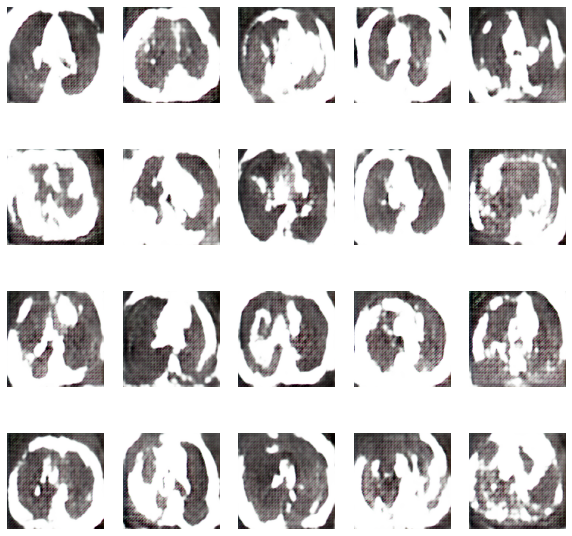

Epoch: 1601/4000, Loss: [D_real = 0.178, D_fake = 0.108, G = 4.311], time: 1.72sec
Epoch: 1602/4000, Loss: [D_real = 0.089, D_fake = 0.290, G = 4.475], time: 1.72sec
Epoch: 1603/4000, Loss: [D_real = 0.280, D_fake = 0.163, G = 3.169], time: 1.73sec
Epoch: 1604/4000, Loss: [D_real = 0.398, D_fake = 0.346, G = 3.826], time: 1.72sec
Epoch: 1605/4000, Loss: [D_real = 0.403, D_fake = 0.398, G = 2.350], time: 1.72sec
Epoch: 1606/4000, Loss: [D_real = 0.143, D_fake = 0.177, G = 3.660], time: 1.72sec
Epoch: 1607/4000, Loss: [D_real = 0.162, D_fake = 0.214, G = 3.854], time: 1.72sec
Epoch: 1608/4000, Loss: [D_real = 0.183, D_fake = 0.209, G = 3.471], time: 1.73sec
Epoch: 1609/4000, Loss: [D_real = 0.135, D_fake = 0.110, G = 3.753], time: 1.72sec
Epoch: 1610/4000, Loss: [D_real = 0.271, D_fake = 0.111, G = 3.792], time: 1.73sec
Epoch: 1611/4000, Loss: [D_real = 0.062, D_fake = 0.162, G = 4.637], time: 1.74sec
Epoch: 1612/4000, Loss: [D_real = 0.088, D_fake = 0.203, G = 4.241], time: 1.72sec
Epoc

> Accuracy at epoch 2000 [real: 100%, fake: 100%]


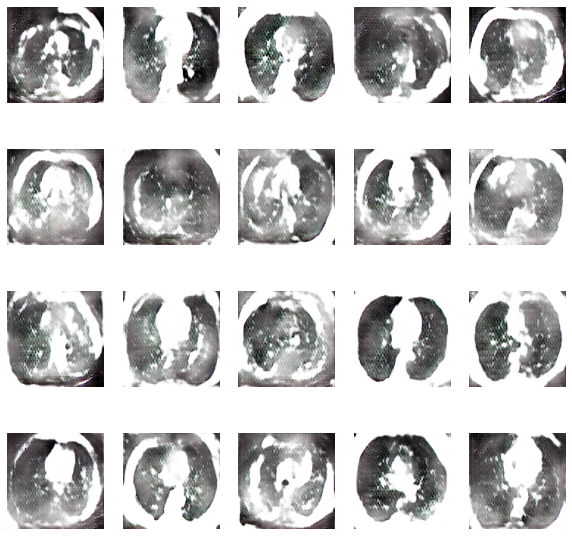

Epoch: 2001/4000, Loss: [D_real = 0.043, D_fake = 0.015, G = 5.550], time: 1.74sec
Epoch: 2002/4000, Loss: [D_real = 0.024, D_fake = 0.024, G = 5.994], time: 1.73sec
Epoch: 2003/4000, Loss: [D_real = 0.034, D_fake = 0.040, G = 6.083], time: 1.72sec
Epoch: 2004/4000, Loss: [D_real = 0.049, D_fake = 0.035, G = 6.454], time: 1.72sec
Epoch: 2005/4000, Loss: [D_real = 0.017, D_fake = 0.031, G = 6.045], time: 1.73sec
Epoch: 2006/4000, Loss: [D_real = 0.071, D_fake = 0.047, G = 5.375], time: 1.73sec
Epoch: 2007/4000, Loss: [D_real = 0.020, D_fake = 0.029, G = 6.848], time: 1.74sec
Epoch: 2008/4000, Loss: [D_real = 0.028, D_fake = 0.030, G = 5.964], time: 1.72sec
Epoch: 2009/4000, Loss: [D_real = 0.046, D_fake = 0.009, G = 6.052], time: 1.72sec
Epoch: 2010/4000, Loss: [D_real = 0.015, D_fake = 0.050, G = 5.771], time: 1.73sec
Epoch: 2011/4000, Loss: [D_real = 0.034, D_fake = 0.039, G = 6.525], time: 1.73sec
Epoch: 2012/4000, Loss: [D_real = 0.020, D_fake = 0.035, G = 6.233], time: 1.72sec
Epoc

> Accuracy at epoch 2400 [real: 100%, fake: 100%]


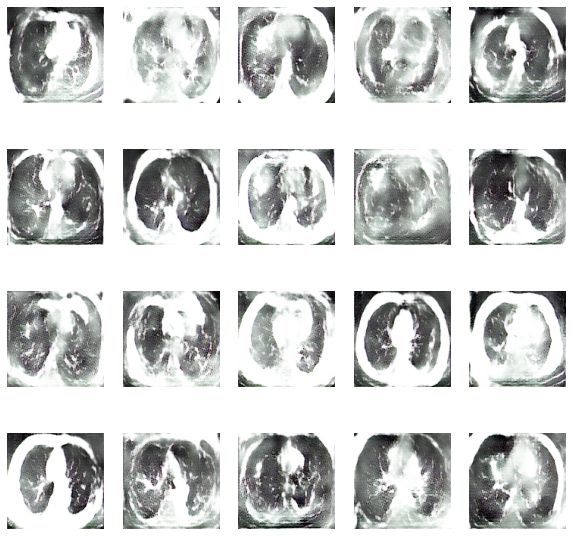

Epoch: 2401/4000, Loss: [D_real = 0.009, D_fake = 0.036, G = 7.629], time: 1.73sec
Epoch: 2402/4000, Loss: [D_real = 0.025, D_fake = 0.023, G = 7.757], time: 1.71sec
Epoch: 2403/4000, Loss: [D_real = 0.056, D_fake = 0.054, G = 6.646], time: 1.71sec
Epoch: 2404/4000, Loss: [D_real = 0.060, D_fake = 0.023, G = 6.741], time: 1.71sec
Epoch: 2405/4000, Loss: [D_real = 0.026, D_fake = 0.023, G = 9.387], time: 1.71sec
Epoch: 2406/4000, Loss: [D_real = 0.005, D_fake = 0.104, G = 8.602], time: 1.73sec
Epoch: 2407/4000, Loss: [D_real = 0.008, D_fake = 0.027, G = 7.167], time: 1.72sec
Epoch: 2408/4000, Loss: [D_real = 0.032, D_fake = 0.009, G = 6.692], time: 1.72sec
Epoch: 2409/4000, Loss: [D_real = 0.005, D_fake = 0.005, G = 7.873], time: 1.71sec
Epoch: 2410/4000, Loss: [D_real = 0.009, D_fake = 0.029, G = 10.008], time: 1.72sec
Epoch: 2411/4000, Loss: [D_real = 0.012, D_fake = 0.113, G = 8.788], time: 1.72sec
Epoch: 2412/4000, Loss: [D_real = 2.059, D_fake = 0.763, G = 5.434], time: 1.71sec
Epo

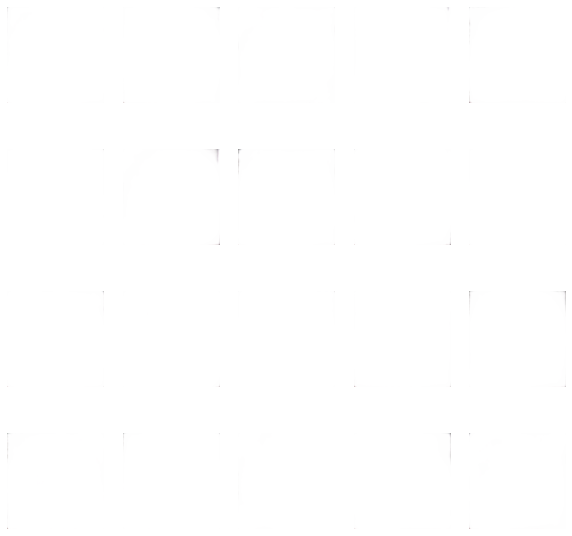

Epoch: 2801/4000, Loss: [D_real = 0.001, D_fake = 0.001, G = 13.587], time: 1.73sec
Epoch: 2802/4000, Loss: [D_real = 0.020, D_fake = 0.000, G = 14.171], time: 1.71sec
Epoch: 2803/4000, Loss: [D_real = 0.007, D_fake = 0.000, G = 12.245], time: 1.72sec
Epoch: 2804/4000, Loss: [D_real = 0.005, D_fake = 0.001, G = 13.720], time: 1.7sec
Epoch: 2805/4000, Loss: [D_real = 0.006, D_fake = 0.000, G = 13.566], time: 1.71sec
Epoch: 2806/4000, Loss: [D_real = 0.005, D_fake = 0.001, G = 13.609], time: 1.72sec
Epoch: 2807/4000, Loss: [D_real = 0.000, D_fake = 0.000, G = 13.020], time: 1.71sec
Epoch: 2808/4000, Loss: [D_real = 0.002, D_fake = 0.000, G = 13.123], time: 1.7sec
Epoch: 2809/4000, Loss: [D_real = 0.006, D_fake = 0.000, G = 12.635], time: 1.71sec
Epoch: 2810/4000, Loss: [D_real = 0.000, D_fake = 0.001, G = 13.257], time: 1.72sec
Epoch: 2811/4000, Loss: [D_real = 0.004, D_fake = 0.000, G = 15.011], time: 1.73sec
Epoch: 2812/4000, Loss: [D_real = 0.034, D_fake = 0.000, G = 13.193], time: 1.

> Accuracy at epoch 3200 [real: 100%, fake: 99%]


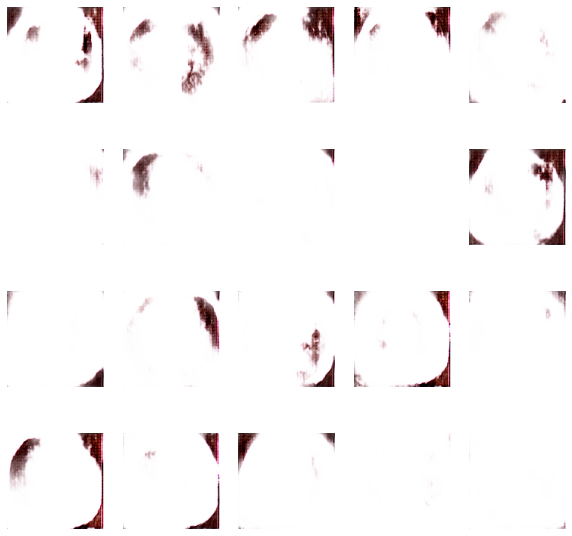

Epoch: 3201/4000, Loss: [D_real = 0.045, D_fake = 0.029, G = 15.059], time: 1.73sec
Epoch: 3202/4000, Loss: [D_real = 0.013, D_fake = 0.002, G = 16.795], time: 1.72sec
Epoch: 3203/4000, Loss: [D_real = 0.054, D_fake = 0.259, G = 14.432], time: 1.72sec
Epoch: 3204/4000, Loss: [D_real = 0.146, D_fake = 0.095, G = 15.945], time: 1.72sec
Epoch: 3205/4000, Loss: [D_real = 0.093, D_fake = 0.077, G = 12.850], time: 1.71sec
Epoch: 3206/4000, Loss: [D_real = 0.304, D_fake = 0.185, G = 14.956], time: 1.72sec
Epoch: 3207/4000, Loss: [D_real = 0.227, D_fake = 0.394, G = 19.628], time: 1.71sec
Epoch: 3208/4000, Loss: [D_real = 0.226, D_fake = 0.138, G = 10.693], time: 1.7sec
Epoch: 3209/4000, Loss: [D_real = 0.477, D_fake = 1.025, G = 14.050], time: 1.7sec
Epoch: 3210/4000, Loss: [D_real = 1.559, D_fake = 1.441, G = 8.065], time: 1.71sec
Epoch: 3211/4000, Loss: [D_real = 1.623, D_fake = 1.874, G = 6.847], time: 1.72sec
Epoch: 3212/4000, Loss: [D_real = 0.755, D_fake = 0.580, G = 5.911], time: 1.71s

> Accuracy at epoch 3600 [real: 100%, fake: 100%]


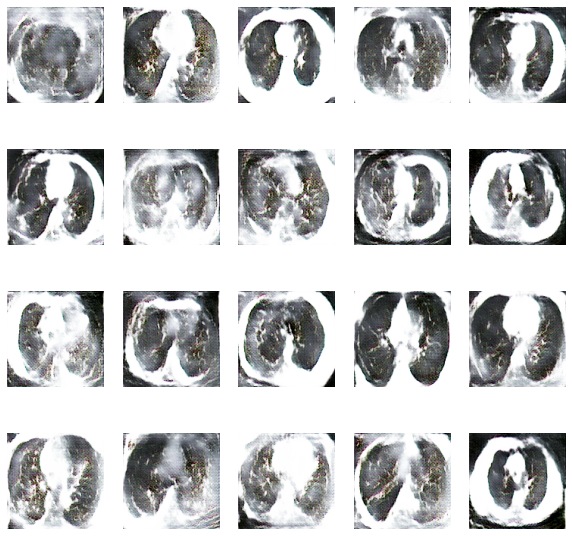

Epoch: 3601/4000, Loss: [D_real = 0.025, D_fake = 0.074, G = 6.053], time: 1.74sec
Epoch: 3602/4000, Loss: [D_real = 0.009, D_fake = 0.023, G = 5.597], time: 1.74sec
Epoch: 3603/4000, Loss: [D_real = 0.235, D_fake = 0.192, G = 5.801], time: 1.72sec
Epoch: 3604/4000, Loss: [D_real = 10.455, D_fake = 0.297, G = 35.213], time: 1.72sec
Epoch: 3605/4000, Loss: [D_real = 1.710, D_fake = 12.173, G = 50.993], time: 1.71sec
Epoch: 3606/4000, Loss: [D_real = 2.464, D_fake = 1.783, G = 18.374], time: 1.72sec
Epoch: 3607/4000, Loss: [D_real = 0.822, D_fake = 0.149, G = 5.836], time: 1.72sec
Epoch: 3608/4000, Loss: [D_real = 0.186, D_fake = 0.029, G = 8.826], time: 1.71sec
Epoch: 3609/4000, Loss: [D_real = 0.276, D_fake = 0.157, G = 7.364], time: 1.71sec
Epoch: 3610/4000, Loss: [D_real = 0.109, D_fake = 0.032, G = 8.066], time: 1.72sec
Epoch: 3611/4000, Loss: [D_real = 0.084, D_fake = 0.029, G = 8.047], time: 1.71sec
Epoch: 3612/4000, Loss: [D_real = 0.094, D_fake = 0.039, G = 7.310], time: 1.72sec

> Accuracy at epoch 4000 [real: 100%, fake: 100%]


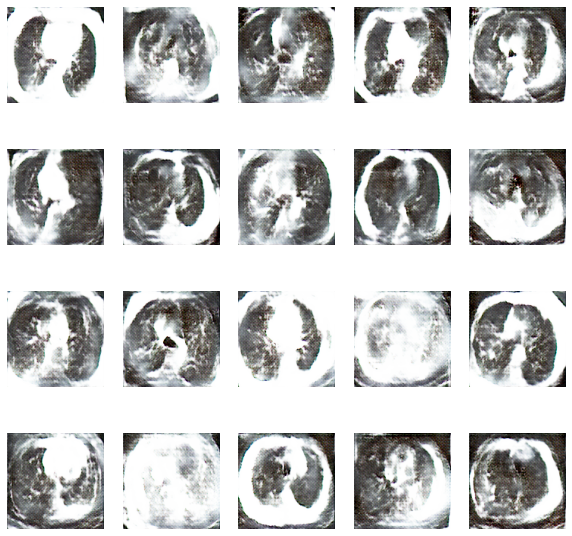

Total time for training 4000 epochs is 1h 55min 19.66sec sec


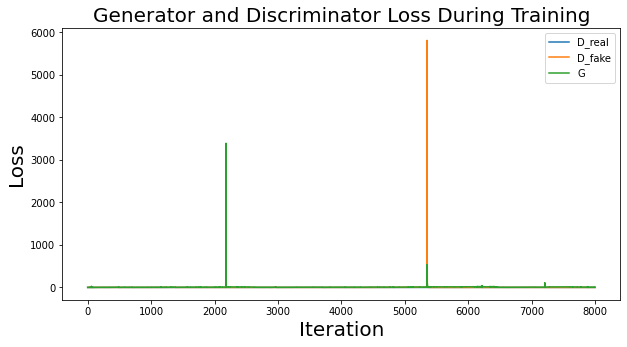

In [ ]:
# train model
#train(generator, discriminator, gan, X_normal, latent_dim, n_epochs=n_epoch, n_batch=batch_size)
print()
#train(generator, discriminator, gan, X_pneumonial, latent_dim, n_epochs=n_epoch, n_batch=batch_size)
print()
train(generator, discriminator, gan, X_covid, latent_dim, n_epochs=n_epoch, n_batch=batch_size)